In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np
import av
import logging
import pickle
from tqdm import tqdm


import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
a_file_path = Path(os.path.join('..','..','pupil_labs_data','GD-Short-Driving-Video'))
#a_file_path = Path(os.path.join('..','..','pupil_labs_data','cb13'))
a_file_path
source = pupil_labs_source(a_file_path)

In [3]:
def set_video_target(self, file_path = False):
    
    if not file_path:
        
        Tk().withdraw()  # we don't want a full GUI, so keep the root window from appearing
        file_path = askopenfilename(title="Select the video on which to overlay gaze",
                                               initialdir=self.recording_folder)
        
    
    self.video_target_path = file_path
    return True


import types
source.set_video_target = types.MethodType( set_video_target, source )


In [4]:
p = Path('D:/Github/retinal_flow_toolkit/pupil_labs_data/GD-Short-Driving-Video/S001/PupilData/007/exports/003/world_nvidia2_hsv_overlay.mp4').as_posix()
# p = Path('D:\Github\retinal_flow_toolkit\pupil_labs_data\GD-Short-Driving-Video\S001\PupilData\007\world.mp4').as_posix()
# p = Path('D:/Github/retinal_flow_toolkit/pupil_labs_data/cb13/S001/PupilData/000/exports/000/cb13_world_nvidia2_hsv_overlay.mp4'
# ).as_posix()

source.set_video_target(p)

True

In [5]:
source.video_target_path

'D:/Github/retinal_flow_toolkit/pupil_labs_data/GD-Short-Driving-Video/S001/PupilData/007/exports/003/world_nvidia2_hsv_overlay.mp4'

In [6]:
img_out_path = 'image_out/'

if os.path.exists(img_out_path) is False:
    os.mkdir(img_out_path)

In [7]:
video = cv2.VideoCapture(source.video_target_path)

In [35]:
success = 1

f = 381
#14627 # rigth turn
video.set(cv2.CAP_PROP_POS_FRAMES, f)
success, image = video.read()

# count = f
# while success:
    
#     success, image = video.read()
    
#     if success:
#         cv2.imwrite(f"{img_out_path}/{count}.jpg", image)
        
#     count = count + 1


# print(count)

In [36]:
success

True

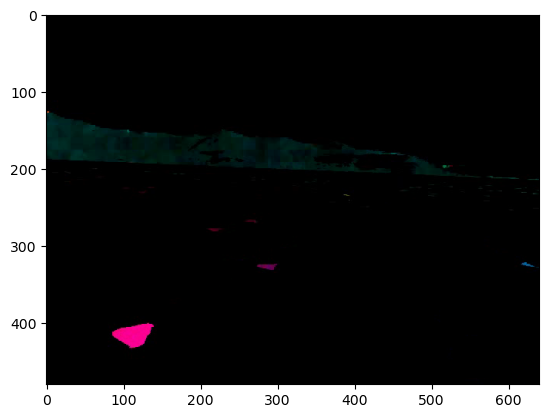

In [37]:
# success, image = video.read()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [38]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
h = hsv_image[...,0]
s = hsv_image[...,1]
v = hsv_image[...,2]
hist_params = (4*4, 0, 360)

### Hue histogram

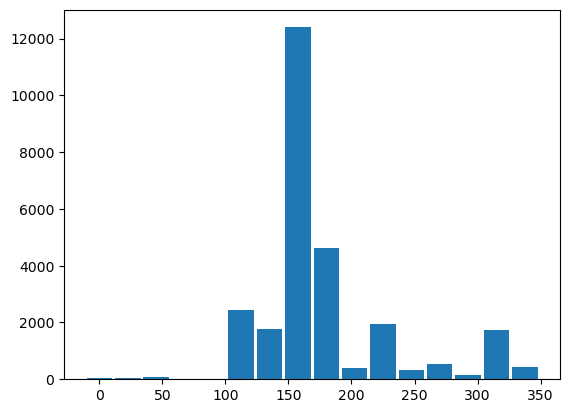

In [39]:
hue_flat = h.flatten()
hue_flat = hue_flat[hue_flat>0] * 2.0


flat_counts, bins = np.histogram(hue_flat, hist_params[0], (hist_params[1], hist_params[2]));
plt.bar(bins[:-1], height=flat_counts, width=.9*(bins[1]-bins[0]));

### histogram with hues rotated 

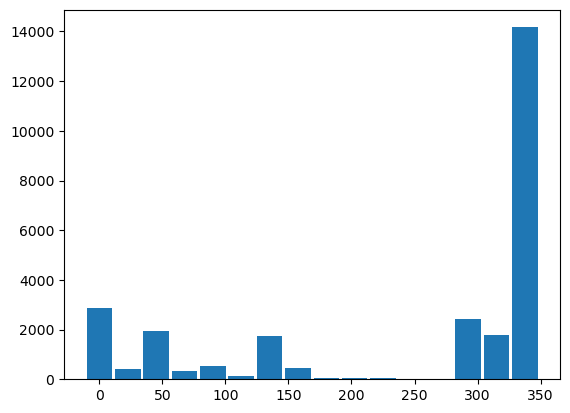

In [40]:
hue_flat = h.flatten()
hue_flat = hue_flat[hue_flat>0] * 2.0
hue_flat = hue_flat + 180
hue_flat[hue_flat>360] = hue_flat[hue_flat>360] - 360


flat_counts, bins = np.histogram(hue_flat, hist_params[0], (hist_params[1], hist_params[2]));
plt.bar(bins[:-1], height=flat_counts, width=.9*(bins[1]-bins[0]));

### Scaled hues

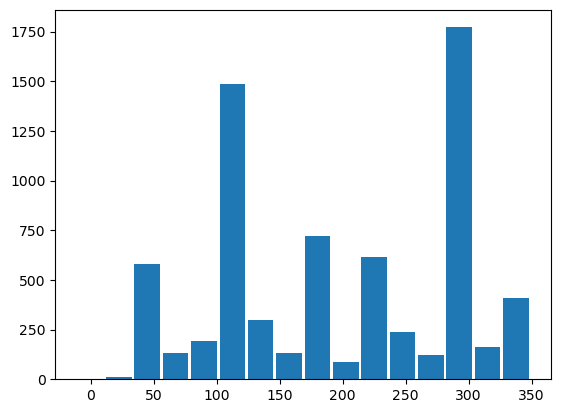

In [41]:
scaled_hue = hue_flat * v.flatten()[h.flatten()>0]

scaled_counts, bins = np.histogram(scaled_hue, hist_params[0], (hist_params[1], hist_params[2]));
plt.bar(bins[:-1], height=scaled_counts, width=.9*(bins[1]-bins[0]));

### Polar histogram of hue counts 

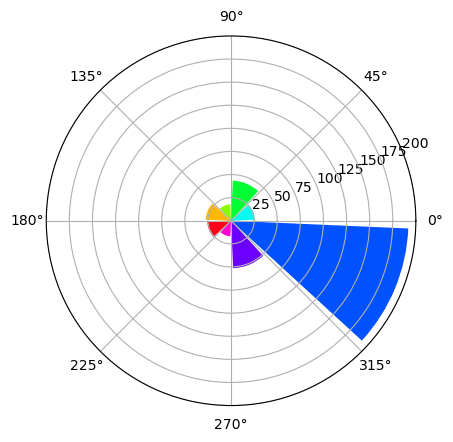

In [55]:
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from collections import deque

bin_rad_hist = deque(maxlen=30)
width = 640
height = 480

dpi = 100
fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), subplot_kw=dict(projection='polar'))
canvas = FigureCanvas(fig)
ax.margins(0)

ax.set_ylim([0, 200])

hist_params = (4 *2, 0, 360)
bins = np.linspace(hist_params[1], hist_params[2], hist_params[0] + 1)
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

cvals = bins[:-1] / 359.0 + .5
cvals[cvals > 1] = cvals[cvals > 1] - 1
hsv_map = cm.get_cmap('hsv').reversed()
bar_colors = hsv_map(cvals)

h = hsv_image[..., 0]
v = hsv_image[..., 2]

mag_flat = v.flatten()[v.flatten() > 10]
hue_flat = h.flatten()[v.flatten() > 10]

hue_flat = hue_flat * 2.0

bin_rad = []
for b_idx in range(1, len(bins)):
    idx = np.where(np.logical_and(hue_flat >= bins[b_idx - 1], hue_flat <= bins[b_idx]))
    bin_rad.append(np.mean(mag_flat[idx]))

bin_rad = np.nan_to_num(bin_rad)
bin_rad_hist.appendleft(bin_rad)

ax.bar(np.deg2rad(bin_centers), np.mean(bin_rad_hist,axis=0), width=2 * (np.pi / (len(bins))), color=bar_colors);

canvas.draw()  # draw the canvas, cache the renderer
image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))

combined_image = np.vstack([image, cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)])



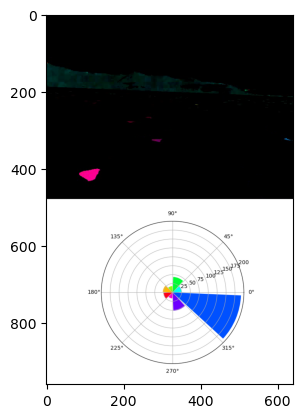

In [56]:
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))

### Color map play

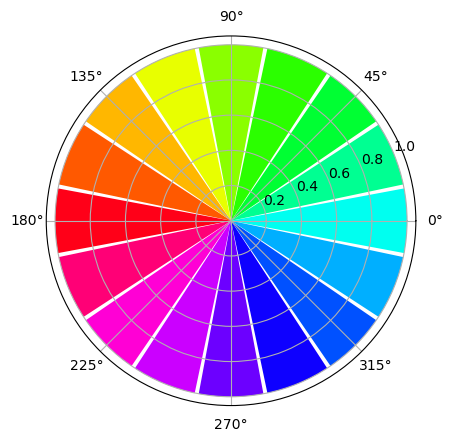

In [16]:
from matplotlib import cm
hsv_map = cm.get_cmap('hsv').reversed()

cvals = bins[:-1]/359.0 +.5
cvals[cvals>1] = cvals[cvals>1]-1
colors = hsv_map(cvals)

counts = np.ones(len(bins)-1)
ax = plt.subplot(111, polar=True)

bars = ax.bar(np.deg2rad(bins[:-1]), counts, width=2*(np.pi / (len(bins))), color=colors)

# ax.set_ylim(.002)
plt.show()

# Mean vector length

In [17]:
mag_flat = v.flatten()[v.flatten()>10]
hue_flat = h.flatten()[v.flatten()>10]

hue_flat = hue_flat[hue_flat>0] * 2.0
# flip the direction around
hue_flat = hue_flat + 180
hue_flat[hue_flat>360] = hue_flat[hue_flat>360] - 360

bins = np.linspace(hist_params[1],hist_params[2], hist_params[0]+1)

bin_rad = []
for b_idx in range(1,len(bins)):
    idx = np.where(np.logical_and(hue_flat>=bins[b_idx-1], hue_flat<=bins[b_idx]))
    bin_rad.append(np.mean(mag_flat[idx]))


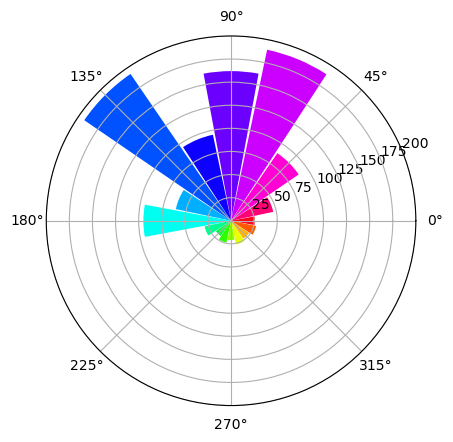

In [18]:

ax = plt.subplot(111, polar=True)

cvals = bins[:-1]/359.0#+.5
#cvals[cvals>1] = cvals[cvals>1]-1
colors = hsv_map(cvals)
bars = ax.bar(np.deg2rad(bins[:-1]), bin_rad, width=2*(np.pi / (len(bins))), color=colors)

ax.set_ylim([0,200])
plt.show()

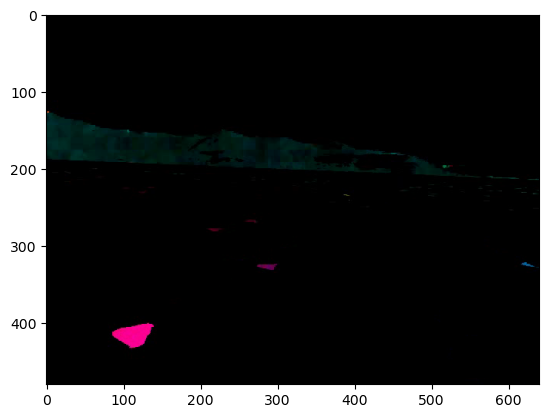

In [19]:
# success, image = video.read()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [20]:
from collections import deque

In [21]:
bin_rad_hist = deque( maxlen=hist_params[0])
bin_rad_hist.appendleft(1*np.ones(3))
bin_rad_hist

deque([array([1., 1., 1.])])

In [22]:
bin_rad_hist.appendleft(5*np.ones(3))
bin_rad_hist

deque([array([5., 5., 5.]), array([1., 1., 1.])])

In [23]:
np.mean(bin_rad_hist,axis=0)

array([3., 3., 3.])